In [24]:
!nvidia-smi

Tue Nov  7 09:04:03 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     Off | 00000000:04:00.0 Off |                  N/A |
| 20%   37C    P0              60W / 250W |      0MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import os
import tensorflow as tf
import sys
import tensorflow_addons as tfa

2023-11-06 17:44:25.482962: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# physical_devices = tf.config.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices), ", GPU ID: ", "0")
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np
import nibabel as nib
import tensorflow as tf
from scipy.ndimage import zoom
# from denseweight import DenseWeight


class Data:
    def __init__(self, args):
        self.args = args
        self.train_pathway = ""
        self.test_pathway = ""
        self.pathway = "/lfs1/pjtoral/cognitive-decline/scripts/data/revised/standardized/mci_included"
        self.dof = "9DOF"
        self.target_column = "MMSE"
        self.batch_size = 1
        # self.transformation = self.args.transformation
        # self.sample_weight = self.args.sample_weight
        # if self.sample_weight == "dense_weight":
        #     self.dense_weight_alpha = experiment_config["alpha"]

        self.train_df = pd.DataFrame()
        self.validation_df = pd.DataFrame()
        self.test_df = pd.DataFrame()
        self.train_batch = pd.DataFrame()
        self.validation_batch = pd.DataFrame()
        self.test_batch = pd.DataFrame()

        self.set_dataframes()
        self.set_data_generators()

    def set_dataframes(self):
        df_train_ADNI1 = pd.read_csv(self.pathway + "/train_ADNI1_" + self.dof + ".csv")
        df_train_ADNI2 = pd.read_csv(self.pathway + "/train_ADNI2_" + self.dof + ".csv")
        df_train_ADNI3 = pd.read_csv(self.pathway + "/train_ADNI3_" + self.dof + ".csv")
        df_test_ADNI1 = pd.read_csv(self.pathway + "/test_ADNI1_" + self.dof + ".csv")
        df_test_ADNI2 = pd.read_csv(self.pathway + "/test_ADNI2_" + self.dof + ".csv")
        df_test_ADNI3 = pd.read_csv(self.pathway + "/test_ADNI3_" + self.dof + ".csv")
        df_train = pd.concat([df_train_ADNI1, df_train_ADNI2, df_train_ADNI3], ignore_index=True).reset_index(drop=True)
        df_test = pd.concat([df_test_ADNI1, df_test_ADNI2, df_test_ADNI3], ignore_index=True).reset_index(drop=True)

        # df_train = pd.read_csv(self.train_pathway)
        # df_test = pd.read_csv(self.test_pathway)

        df_train.dropna(subset=[self.target_column], inplace=True)
        df_test.dropna(subset=[self.target_column], inplace=True)
        self.test_df = df_test
        self.split_dataframes(df_train)

    def split_dataframes(self, df_train):
        df_train.reset_index(inplace=True)
        df_validation = pd.DataFrame()
        # ADNI
        df_train["subj_id"] = ["_".join(x.split("/")[-1].split("_")[:3]) for x in df_train['volume']]
        sgkf = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=7)
        (train_idxs, validation_idxs) = next(
            sgkf.split(df_train.drop(columns=["label"]), df_train["label"], groups=df_train["subj_id"]))
        df_train_ = df_train.iloc[train_idxs]
        df_validation = df_train.iloc[validation_idxs]

        sgkf.split(df_validation.drop(columns=["label"]), df_validation["label"], groups=df_validation["subj_id"])
        (train_addition_idx, true_validation_idxs) = next(
            sgkf.split(df_validation.drop(columns=["label"]), df_validation["label"], groups=df_validation["subj_id"]))
        df_train_ = pd.concat([df_train_, df_validation.iloc[train_addition_idx]], ignore_index=True)
        df_validation = df_validation.iloc[true_validation_idxs]

        df_train = df_train_.copy()
        self.train_df = df_train
        self.validation_df = df_validation

    def set_data_generators(self):
        train_x = self.train_df["volume"].to_numpy()
        train_y = self.train_df[self.target_column].to_numpy().astype(np.float32)
        validate_x = self.validation_df["volume"].to_numpy()
        validate_y = self.validation_df[self.target_column].to_numpy().astype(np.float32)
        test_x = self.test_df["volume"].to_numpy()
        test_y = self.test_df[self.target_column].to_numpy().astype(np.float32)


        # if self.sample_weight == "dense_weight":
        #     dw = DenseWeight(alpha=self.dense_weight_alpha)
        #     sample_weights = dw.fit(train_y)
        #     self.train_batch = self.DataGenerator(train_x, train_y, self.batch_size, sample_weights)

        self.train_batch = self.DataGenerator(train_x, train_y, self.batch_size)
        self.validation_batch = self.DataGenerator(validate_x, validate_y, self.batch_size)
        self.test_batch = self.DataGenerator(test_x, test_y, self.batch_size)

    class DataGenerator(tf.keras.utils.Sequence):
        def read_scan(self, path):
            scan = nib.load(path)
            original_volume = scan.get_fdata()
            original_volume_normalized = self.normalize(original_volume)
#             resized_volume = self.resize(original_volume_normalized)
            return tf.expand_dims(original_volume_normalized, axis=3)

        def normalize(self, volume):
            min = np.amax(volume)
            max = np.amin(volume)
            volume = (volume - min) / (max - min)
            volume = volume.astype("float32")
            return volume

        def resize(self, original_volume, w=96, h=96, d=96):
            zoom_factors = (w / original_volume.shape[0], h / original_volume.shape[1], d / original_volume.shape[2])
            resized_volume = zoom(original_volume, zoom_factors)
            resized_volume_normalized = self.normalize(resized_volume)
            return resized_volume_normalized

        def display(self):
            path = self.image_filenames[0]
            scan = nib.load(path)
            print(path)
            original_volume = scan.get_fdata()
            original_volume_normalized = self.normalize(original_volume)
            resized_volume = self.resize(original_volume_normalized)
        
            # Get the middle slice of the original image
            original_slice = original_volume[:, :, original_volume.shape[2] // 2]
            # Get the middle slice of the resized image
            resized_slice = resized_volume[:, :, resized_volume.shape[2] // 2]
            #
            # Plot the slices
            plt.figure(figsize=(12, 6))
            plt.imshow(original_slice, cmap='gray')
            plt.title('Original Image ' + str(original_volume_normalized.shape))
            plt.show()
            plt.imshow(resized_slice, cmap='gray')
            plt.title('Resized Image ' + str(resized_volume.shape))
            plt.show()

        def __init__(self, image_filenames, labels, batch_size, sample_weights=None):
            self.image_filenames = image_filenames
            self.labels = labels
            self.batch_size = batch_size

        def __len__(self):
            return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)

        def __getitem__(self, idx):
            batch_x = self.image_filenames[idx * self.batch_size: (idx + 1) * self.batch_size]
            batch_y = self.labels[idx * self.batch_size: (idx + 1) * self.batch_size]
            return (np.asarray([self.read_scan(path) for path in batch_x]), np.array(batch_y))

In [5]:
args = {}
data = Data(args)
test_batch = data.test_batch
test_df = data.test_df
# test_batch.display()

In [6]:
def display_prediction_plot(test_y,y_pred,colors,label,ax):
    plt.figure()
    rmse = round(mean_squared_error(test_y,y_pred),2)
    mae = round(mean_absolute_error(test_y,y_pred),2)
    r2 = round(r2_score(test_y,y_pred),2)
    p1 = max(max(y_pred), max(test_y))
    p2 = 0
    sns.set_style("whitegrid")
    # plt.xlim(10, 31)
    # plt.ylim(10, 31)
    sns.regplot(x=test_y, y=y_pred,color="crimson",ax=ax,line_kws={'color':'r',"label":"Regression Line of Model Predictions"},scatter_kws={'color': list(colors),'alpha':0.2,'s':8.5,"label":"Predictions"}) #,})
    ax.plot([p1, p2], [p1, p2], 'g',label="Perfect Prediction Line")
    ax.set_title(label+", MAE: "+str(mae)+", MSE: "+str(rmse), fontsize=12)
    ax.set_xlabel('True Values, Mean: '+str(round(np.mean(test_y),2)), fontsize=10)
    ax.set_ylabel('Predictions, Mean: '+str(round(np.mean(y_pred),2)), fontsize=10)
    
    ax.axis('equal')
    ax.legend()
    

In [32]:
def display_prediction_barplot(df,column,label,ax,predictions="model_predictions"):
    
    test_y = df[str(column)].to_numpy()
    y_pred = df[predictions].to_numpy()
    rmse = round(mean_squared_error(test_y,y_pred),2)
    mae = round(mean_absolute_error(test_y,y_pred),2)
    r2 = round(r2_score(test_y,y_pred),2)
    inner_df = pd.DataFrame({"test":test_y,"pred":y_pred})
    inner_df["quantiles"] = pd.qcut(inner_df["test"],q=5)
    mse_by_quantile = inner_df.groupby('quantiles').apply(lambda x: mean_squared_error(x['test'], x['pred']))
    rmse_by_quantile = inner_df.groupby('quantiles').apply(lambda x: math.sqrt(mean_squared_error(x['test'], x['pred'])))
    mae_by_quantile = inner_df.groupby('quantiles').apply(lambda x: mean_absolute_error(x['test'], x['pred']))
    r2_by_quantile = inner_df.groupby('quantiles').apply(lambda x: r2_score(x['test'], x['pred']))
    
#     if "log_transformed" in column:
#         ax.set_yticks([0.0,0.2,0.4,0.6,0.8])
    
    sns.barplot(data=pd.DataFrame(data={"quantile":inner_df["quantiles"].sort_values().unique().astype(str)\
                                        ,"rmse":rmse_by_quantile}), x="quantile", y="rmse",ax=ax,palette=colors)
    

    ax.xlabel('Segment of True Values', fontsize=14)
    ax.ylabel('Prediction Root Mean Squared Error (RMSE)', fontsize=14)
    ax.title(label, fontsize=18)
    



In [51]:
def display_loss_plot(df,arch,axes):
    
#     rmse1 = df['mse'].values #'auc roc'
#     mae1 = df['mae'].values #'val_auc_roc'
    loss = df['loss'].values
    val_loss = df['val_loss'].values

    epo = range(len(loss))


#     axes[1].plot(epo, rmse1, 'b', label='Training MSE')
#     axes[1].plot(epo, mae1, 'r', label='Training MAE')
#     axes[1].set_title(arch+' Training mse and mae')
#     axes[1].legend()

    i = len(axes)-1
    val_loss_min = round(np.min(val_loss),1)
    val_loss_epoch = np.argmin(val_loss)
    axes[i].plot(epo, loss, 'b', label='Training Loss')
    axes[i].plot(epo, val_loss, 'r', label='Validation Loss')
    axes[i].set_title(arch+' Training and Validation (MSE)')
    axes[i].plot(val_loss_epoch, val_loss_min, marker='o', markersize=8, color='red', label="Model for evaluation chosen at: "+str(val_loss_min)+" MSE")

#     axes[1].text(val_loss_epoch, val_loss_min, "Model Evaluation chosen at: "+str(val_loss_min), ha='left', va='bottom')
#     axes[1].legend()
    axes[i].legend()
    axes[i].set_xlabel('Epocs', fontsize=10)
    axes[i].set_ylabel('Mean Squared Error (MSE)', fontsize=10)

#     plt.show()

In [47]:
tiny_vgg_pathway = "tiny_vgg_baseline__2023-11-02_16:25:18"
resnet_pathway = "resnet_baseline_no_wd__2023-11-04_15:40:36"
resnet_tl_pathway = "resnet_tl__2023-11-07_14:55:48"
tcnn_pathway = "tcnn_baseline_no_wd__2023-11-04_15:39:30"
dn_pathway = "densnet_baseline_no_wd__2023-11-05_16:55:03"

test_dx = test_df["label"].values
test_dx = ["r" if val == 0 else "r" for val in test_dx]
resnet = pd.read_csv("../output/"+resnet_pathway+"/"+resnet_pathway+"_predictions.csv")
tcnn = pd.read_csv("../output/"+tcnn_pathway+"/"+tcnn_pathway+"_predictions.csv")
# python main.py -g 0 -bs 4 -tc MMSE -ma vgg -ilr 0.01 -wd 0.0 -en tiny_vgg_baseline -l mse -es 35 -do 0.4
tiny_vgg = pd.read_csv("../output/"+tiny_vgg_pathway+"/"+tiny_vgg_pathway+"_predictions.csv")
vit = pd.read_csv("../output/vision_transformer_lower_wd__2023-10-23_10:52:38/vision_transformer_lower_wd__2023-10-23_10:52:38_predictions.csv")
dn = pd.read_csv("../output/"+dn_pathway+"/"+dn_pathway+"_predictions.csv")

resnet["label"] = test_dx
tcnn["label"] = test_dx
tiny_vgg["label"] = test_dx
dn["label"] = test_dx

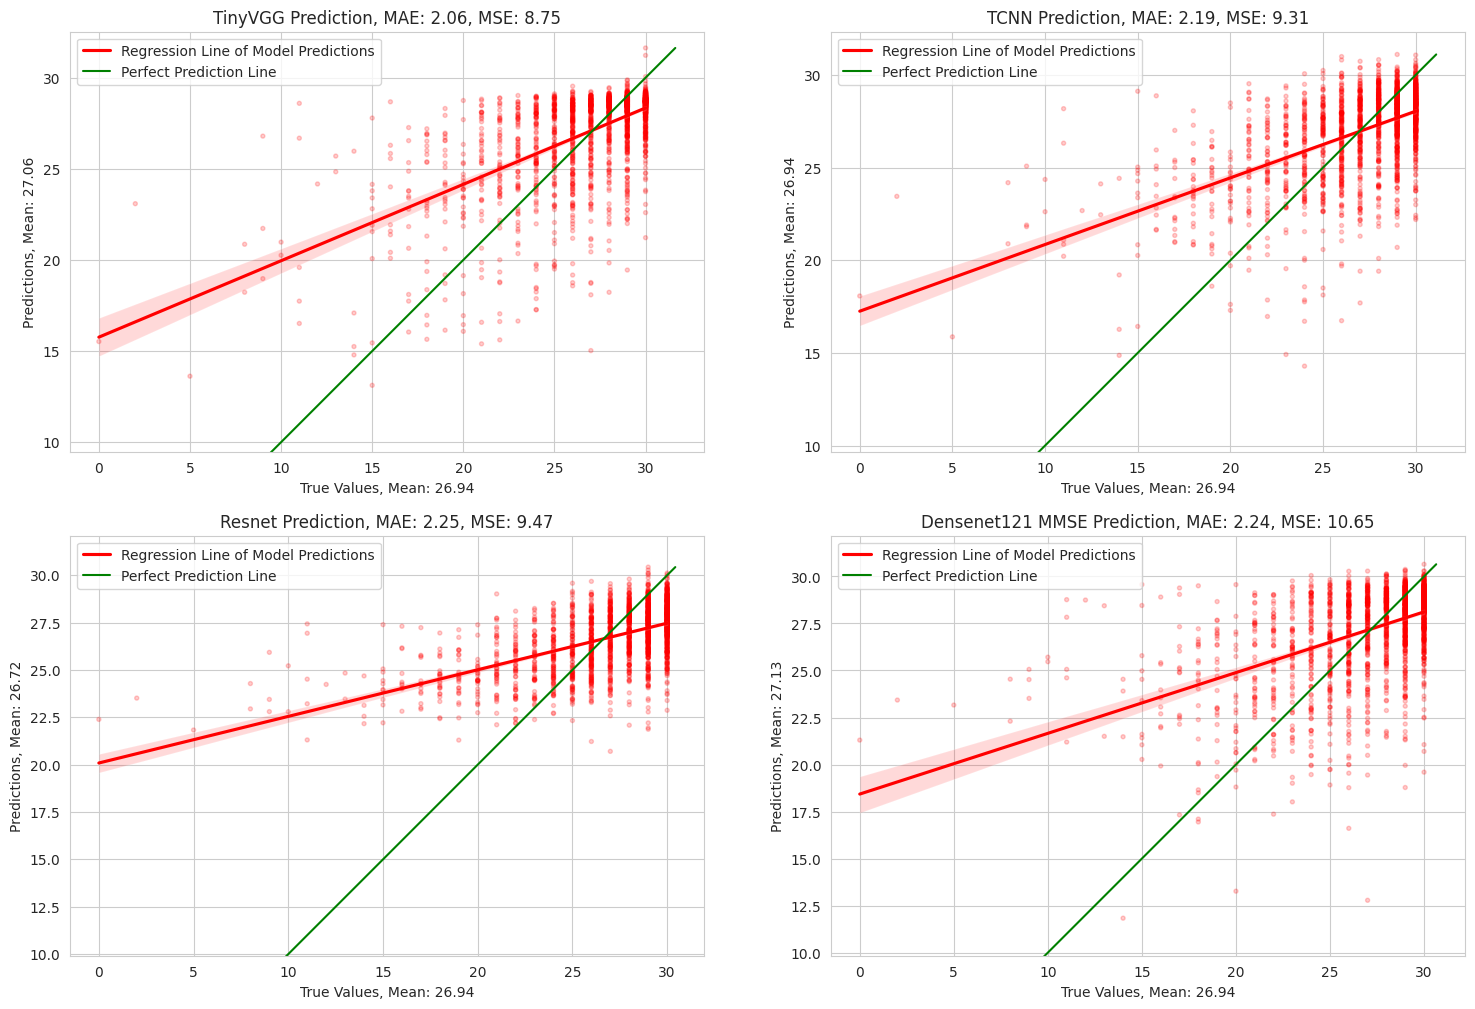

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [41]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(18, 12)

display_prediction_plot(resnet["true_labels"].values,resnet["predictions"].values,resnet["label"].values,"Resnet Prediction", axes[1,0])
display_prediction_plot(tcnn["true_labels"].values,tcnn["predictions"].values,tcnn["label"].values,"TCNN Prediction", axes[0,1])
display_prediction_plot(dn["true_labels"].values,dn["predictions"].values,dn["label"].values,"Densenet121 MMSE Prediction", axes[1,1])
display_prediction_plot(tiny_vgg["true_labels"].values,tiny_vgg["predictions"].values,tiny_vgg["label"].values,"TinyVGG Prediction", axes[0,0])

axes[0,0].set_ylim(10,32)
axes[0,1].set_ylim(10,32)
axes[1,0].set_ylim(10,32)
axes[1,1].set_ylim(10,32)
plt.suptitle("Model Predictions")
plt.tight_layout()
plt.show()



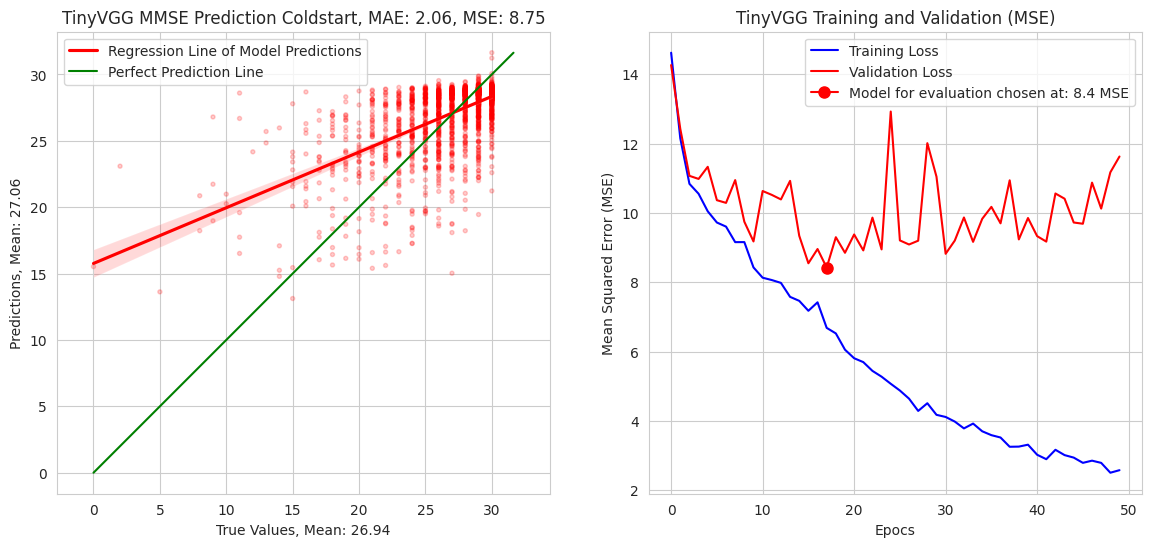

<Figure size 640x480 with 0 Axes>

In [43]:
# Loss analyzer for TinyVGG
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
tiny_vgg_output = pd.read_csv("../output/"+tiny_vgg_pathway+"/"+tiny_vgg_pathway+"_history.csv")
display_loss_plot(tiny_vgg_output,"TinyVGG",axs)
display_prediction_plot(tiny_vgg["true_labels"].values,tiny_vgg["predictions"].values,tiny_vgg["label"].values,"TinyVGG MMSE Prediction Coldstart", axs[0])
plt.tight_layout()
plt.show()

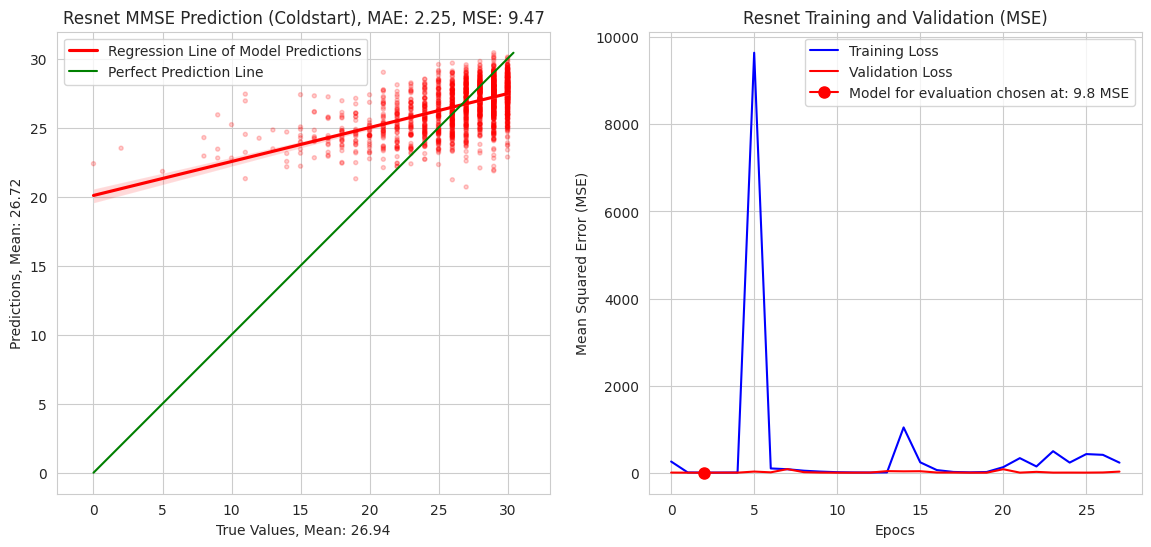

<Figure size 640x480 with 0 Axes>

KeyError: 'mse'

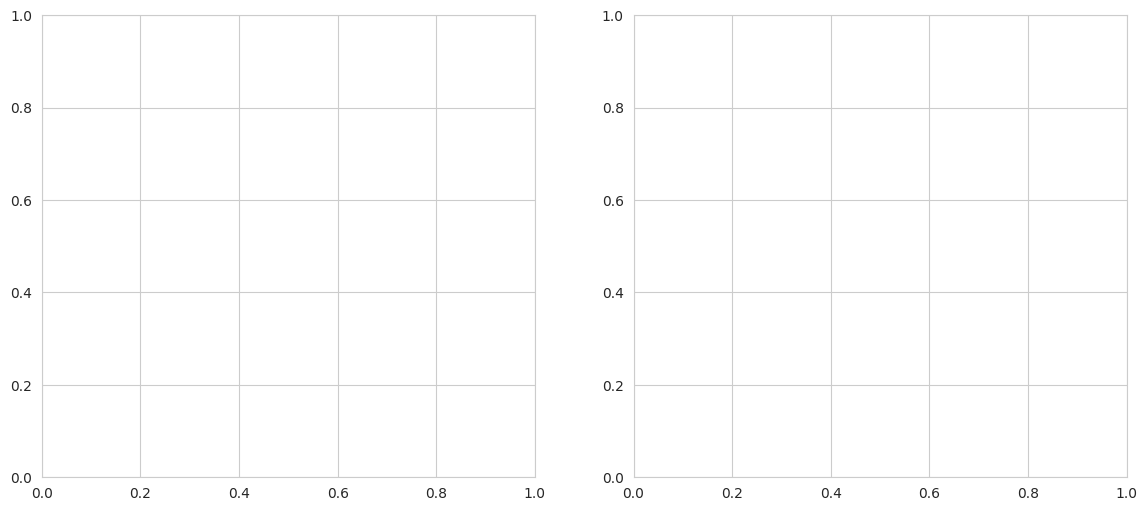

In [50]:
# Loss analyzer for Resnet
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
resnet_output = pd.read_csv("../output/"+resnet_pathway+"/"+resnet_pathway+"_history.csv")
display_loss_plot(resnet_output,"Resnet",axs)
display_prediction_plot(resnet["true_labels"].values,resnet["predictions"].values,resnet["label"].values,"Resnet MMSE Prediction (Coldstart)", axs[0])
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
resnet_output_tl = pd.read_csv("../output/"+resnet_tl_pathway+"/"+resnet_tl_pathway+"_history.csv")
display_loss_plot(resnet_output_tl,"Resnet",axs)


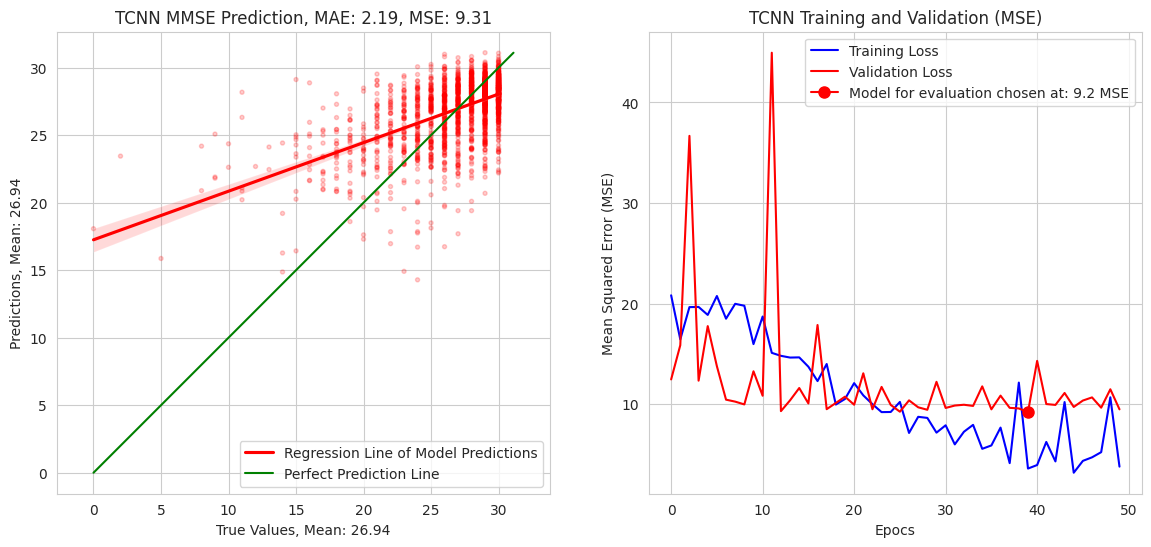

<Figure size 640x480 with 0 Axes>

In [23]:
# Loss analyzer for TCNN
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
tcnn_output = pd.read_csv("../output/"+tcnn_pathway+"/"+tcnn_pathway+"_history.csv")
display_loss_plot(tcnn_output,"TCNN",axs)
display_prediction_plot(tcnn["true_labels"].values,tcnn["predictions"].values,tcnn["label"].values,"TCNN MMSE Prediction", axs[0])
plt.tight_layout()
plt.show()